# replicate the sine model to check if we can deploy the model onto the MCU

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import onnx

import numpy as np
import matplotlib.pyplot as plt
import math
import time

### check if mps support is available -metal performance shaders

In [2]:
torch.backends.mps.is_available()

True

In [3]:
torch.backends.mps.is_built()

True

In [4]:
# we can use it by setting the mps device
mps = torch.device("mps")
cpu = torch.device("cpu")

# create data

In [5]:
SAMPLES = 100000
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
# generate random numbers
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# shuffle the values
np.random.shuffle(x_values)

# calculate corresponding y values
y_values = np.sin(x_values)

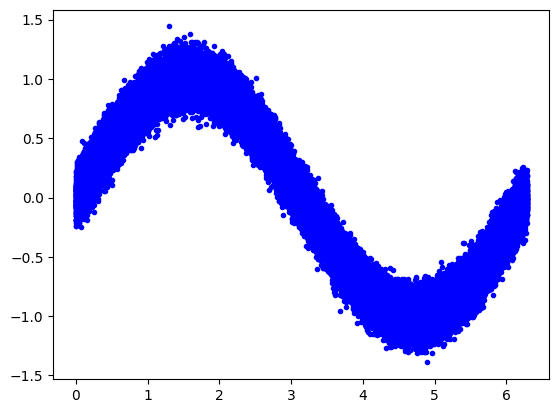

In [7]:
# add noise
y_values += 0.1 * np.random.randn(y_values.shape[0])

plt.plot(x_values, y_values, 'b.')
plt.show()

In [8]:
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

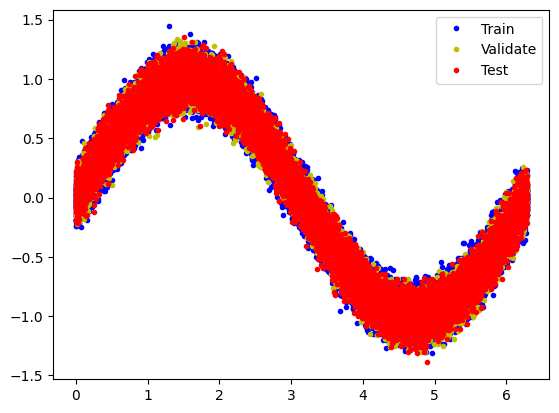

In [9]:
# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

# model


In [10]:
# shape should resemble the one used in the tensorflow tutorial

class Mlp(nn.Module):
    def __init__(self):
        super(Mlp, self).__init__()
        # input layer
        self.fc1 = nn.Linear(1, 16)
        # hidden layer
        self.fc2 = nn.Linear(16, 16)
        # output layer, no activation
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        # forward loop to propagate through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## implement dataset and data loader

In [11]:
class SineDataset(Dataset):
    
    def __init__(self, data):
         # data is tuple of input and target
        self.x_data = data[0]
        self.y_data = data[1]
        assert len(self.x_data) == len(self.y_data)
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # transform data to tensor and unsqueeze to fit the dimensions
        example = torch.unsqueeze(torch.tensor(self.x_data[idx], dtype=torch.float), dim=0)
        target = torch.unsqueeze(torch.tensor(self.y_data[idx], dtype=torch.float), dim=0)
        
        return example, target

In [12]:
def train_with_loader(model, loader, opti, crit, device):
    
    model.to(device)
    
    epoch_train_loss = list()

    for _data in loader:
        # send data to device
        _inpt = _data[0].to(device)
        _trgt = _data[1].to(device)

        # make prediction
        _otp = model(_inpt)
        # compute loss
        loss = crit(_otp.to(device), _trgt).requires_grad_(True)
        # zero out gradients
        opti.zero_grad()
        # backward pass
        loss.backward()       
        # optimization step
        opti.step()

        epoch_train_loss.append(loss.detach().cpu().numpy())

    return model, np.average(epoch_train_loss)

In [13]:
def validate_with_loader(model, loader, device, crit):

    model.to(device)

    val_loss = list()

    for _data in loader:
        # send data to device
        _inpt = _data[0].to(device)
        _trgt = _data[1].to(device)

        # make prediction
        _otp = model(_inpt)
        # compute loss
        loss = crit(_otp.to(device), _trgt)

        val_loss.append(loss.detach().cpu().numpy())
    
    return np.average(val_loss)

In [21]:
EPOCHS = 1000
LR = 0.001
BATCH_SIZE = 400
DEVICE = cpu

criterion = nn.MSELoss()

# init model and send to desired device
mlp_3 = Mlp()

optimizer = torch.optim.RMSprop(mlp_3.parameters(), lr=LR)

# init datasets
train_ds = SineDataset((x_train, y_train))
val_ds = SineDataset((x_validate, y_validate))

# dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
start = time.time()

train_loss = list()
val_loss = list()

for epoch in range(EPOCHS):
    # training step
    mlp_3.train()
    mlp_3, t_loss_epoch = train_with_loader(mlp_3, train_loader, optimizer, criterion, DEVICE)
    train_loss.append(t_loss_epoch)
    
    # validation step
    mlp_3.eval()
    v_loss_epoch = validate_with_loader(mlp_3, val_loader, DEVICE, criterion)
    val_loss.append(v_loss_epoch)
    
    print(f"EPOCH {epoch+1}: Training loss is {t_loss_epoch:.4f} - Validation loss is {v_loss_epoch:.4f}")

duration = round((time.time() - start), 2)
print(f"That took {duration} seconds")

EPOCH 1: Training loss is 0.2334 - Validation loss is 0.1466
EPOCH 2: Training loss is 0.1366 - Validation loss is 0.1235
EPOCH 3: Training loss is 0.1143 - Validation loss is 0.1033
EPOCH 4: Training loss is 0.0945 - Validation loss is 0.0843
EPOCH 5: Training loss is 0.0755 - Validation loss is 0.0662
EPOCH 6: Training loss is 0.0586 - Validation loss is 0.0510
EPOCH 7: Training loss is 0.0453 - Validation loss is 0.0395
EPOCH 8: Training loss is 0.0355 - Validation loss is 0.0308
EPOCH 9: Training loss is 0.0281 - Validation loss is 0.0241
EPOCH 10: Training loss is 0.0228 - Validation loss is 0.0195
EPOCH 11: Training loss is 0.0194 - Validation loss is 0.0167
EPOCH 12: Training loss is 0.0172 - Validation loss is 0.0151
EPOCH 13: Training loss is 0.0159 - Validation loss is 0.0139
EPOCH 14: Training loss is 0.0150 - Validation loss is 0.0132
EPOCH 15: Training loss is 0.0144 - Validation loss is 0.0127
EPOCH 16: Training loss is 0.0140 - Validation loss is 0.0123
EPOCH 17: Trainin

In [24]:
test_ds = SineDataset((x_test, y_test))
test_loader = DataLoader(test_ds, batch_size=10, shuffle=False)

test_loss = validate_with_loader(mlp_3, test_loader, DEVICE, criterion)

print(test_loss)

0.010222538


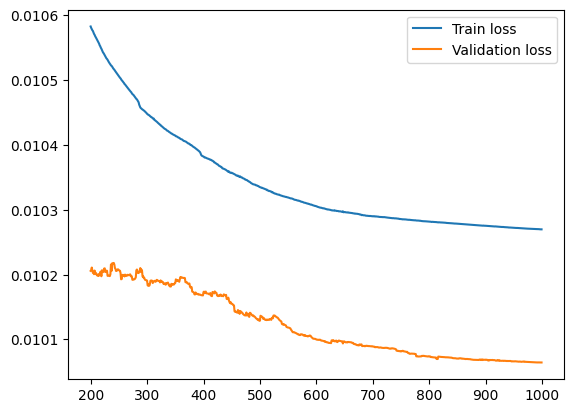

In [26]:
# we cut off the first epochs to get a better view
CUTOFF = 200

plt.plot(range(EPOCHS)[CUTOFF:],train_loss[CUTOFF:], label='Train loss')
plt.plot(range(EPOCHS)[CUTOFF:], val_loss[CUTOFF:], label='Validation loss')
plt.legend()
plt.show()

n = 100000, 10 epochs

cpu, 50, 6.45, 0.011201986

cpu, 100, 5.43, 0.010451091

cpu, 200, 5.11, 0.011088499

cpu, 400, 4.9, 0.011558571

cpu, 1000, 5.54, 0.022512997

cpu, 2000, 6.22, 0.060544275

cpu, 4000, 6.17, 0.094894916

cpu, 8000, 6.44, 0.10684962

cpu, 16k, 6.61, 0.26704338

cpu, 32k, 6.7, 0.3096023

cpu, 64k, 6.86, 0.307854


mps, 50, 39.75, 0.010830567

mps, 100, 21.41, 0.048968475

mps, 200, 1.49, 0.038196806

mps, 400, 1.95, 0.06830369

mps, 1000, 7.34, 0.033025466

mps, 2000, 7.17, 0.07058245

mps, 4000, 7.19, 0.060544275

mps, 8000, 7.12, 0.11826357

mps, 16k, 7.09, 0.12823954

mps, 32k, 7.14, 0.20471583

mps, 64k, 7.52, 0.3468979

n = 1000, 100 epochs

device, bs, time, test-loss

cpu, 1, 10.01

cpu, 50, 0.69, 0.03647747

cpu, 100, 0.58, 0.032128144

cpu, 200, 0.6, 0.033303432

cpu, 400, 0.56, 0.07653184

mps, 1, 174.4, 0.013676792


mps, 100, 22.05, 0.010148561

mps, 400, 9.12, 0.016021524


## bottom line is: cpu is much faster here

# save model as onnx file

In [55]:
# create an example loader yielding only one example
example_loader = DataLoader(train_ds, batch_size=1, shuffle=True)

In [54]:
# get example input tensor
x = next(iter(example_loader))[0]

x.shape

torch.Size([1, 1])

In [63]:
# define model name
onnx_model_name = "../models/torch_sine.onnx"
# export as onnx file
torch.onnx.export(mlp_3, x, onnx_model_name, export_params=True, do_constant_folding=True)

In [52]:
# load model
onnx_model = onnx.load(onnx_model_name)

# check model
onnx.checker.check_model(onnx_model)

# load model in tensorflow, test and convert

In [113]:
import tensorflow as tf
from onnx_tf.backend import prepare

import os

In [65]:
# load model via onnx
tf_onnx_model = onnx.load(onnx_model_name)

# store model in a directory
tf_onnx_dir = "../models/tf_onnx_model"
prepare(tf_onnx_model).export_graph(tf_onnx_dir)

INFO:tensorflow:Assets written to: ../models/tf_onnx_model/assets


INFO:tensorflow:Assets written to: ../models/tf_onnx_model/assets


In [66]:
# load model in tensorflow
tf_model = tf.saved_model.load(tf_onnx_dir)

In [68]:
# setup for inference
infer = tf_model.signatures["serving_default"]

outputs = list(infer.structured_outputs)

In [100]:
# convert our test tensor to a tensorflow readable input
x_tf = tf.constant(x.numpy())

In [106]:
# verify outputs of both models

initial_output = float(mlp_3(x).detach().numpy())
tf_output = float(infer(x_tf)[outputs[0]].numpy())

initial_output == tf_output

True

# now we need to convert to tf lite and make optimizations

In [112]:
# create a converter and convert saved model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(tf_onnx_dir)
tflite_model = converter.convert()

# store the model on disk without quantization
with open("../models/onnx_sine_model.tflite", "wb") as f:
    f.write(tflite_model)

2023-01-05 20:38:35.101690: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-05 20:38:35.101706: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-05 20:38:35.101827: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ../models/tf_onnx_model
2023-01-05 20:38:35.102113: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-05 20:38:35.102118: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: ../models/tf_onnx_model
2023-01-05 20:38:35.102874: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-01-05 20:38:35.111445: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: ../models/tf_onnx_model
2023-01-05 20:38:35.114140: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: succ

In [127]:
# convert and store with quantization

converter_q = tf.lite.TFLiteConverter.from_saved_model("../models/tf_onnx_model")
converter_q.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_generator():
    for value in x_test:
        # Each scalar value must be inside of a 2D array that is wrapped in a list
        yield [np.array(value, dtype=np.float32, ndmin=2)]

converter_q.representative_dataset = representative_dataset_generator

tflite_model_q = converter_q.convert()

with open("../models/onnx_sine_model_q.tflite", "wb") as f:
    f.write(tflite_model_q)


2023-01-05 21:17:33.947937: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-05 21:17:33.947954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-05 21:17:33.948073: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: ../models/tf_onnx_model
2023-01-05 21:17:33.948379: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-05 21:17:33.948385: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: ../models/tf_onnx_model
2023-01-05 21:17:33.949110: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-01-05 21:17:33.955926: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: ../models/tf_onnx_model
2023-01-05 21:17:33.959028: I tensorflow/cc/saved_model/loader.cc:305] SavedModel load for tags { serve }; Status: succ

In [128]:
basic_model_size = os.path.getsize("../models/onnx_sine_model.tflite")
quantized_model_size = os.path.getsize("../models/onnx_sine_model_q.tflite")

print(f"basic model size is {basic_model_size}")
print(f"quantized model size is {quantized_model_size}")

basic model size is 2864
quantized model size is 2672


In [ ]:
# Save the file as a C source file
# !xxd -i ../models/onnx_sine_model_q.tflite > ../models/onnx_sine_model_q.cc
!xxd -i ../models/onnx_sine_model.tflite > ../models/onnx_sine_model.cc

: 